## Загрузим нужные библиотеки

In [709]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, Pool, cv
import re
import warnings
warnings.filterwarnings('ignore')
import phik
from phik.report import plot_correlation_matrix
from phik import report
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score, cross_validate
import shap
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC
from sklearn.model_selection import KFold
%matplotlib inline

Произведем чтение необходимых датафреймов

In [710]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_tasks = pd.read_csv("Tasks.csv")
df_calls = pd.read_csv("Calls.csv")
df_connection_time = pd.read_csv("ConnectionTime.csv")
df_ed = pd.read_csv("Education.csv")
df_sk = pd.read_csv("SKUD.csv")
df_time_in_network = pd.read_csv("TimenNetwork.csv")
df_workingday = pd.read_csv("WorkingDay.csv")

In [711]:
agg_func = ['sum', 'mean', 'median', 'min', 'max', 'std', 'var', 'mad', 'count'] # 'prod'
SEED = 0
#agg_func = ['mean'] # 'prod'

## Рассмотрим датасет по ближе

In [712]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [713]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [714]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [715]:
df_tasks.head(3)

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588


In [716]:
df_train.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [717]:
df_test.head(3)

,id,type
0,ОРГ1-02649,3
1,ОРГ2-05929,0
2,ОРГ2-05859,2


In [718]:
df_sk.head(3)

,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
0,"2021-03-01 00:00:00,000","1899-12-30 08:11:00,000","1899-12-30 17:32:00,000","9,35","8,35",Будни,ОРГ1-00791
1,"2021-03-01 00:00:00,000","1899-12-30 08:25:00,000","1899-12-30 17:32:00,000","9,1166666666666671","8,1166666666666671",Будни,ОРГ1-01826
2,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-00713


In [719]:
df_time_in_network.head(3)

,Вых/Будни,monitor_Time,startTime,id
0,Будни,300,"2021-08-16 00:00:00,000",ОРГ1-01402
1,Будни,300,"2021-08-18 00:00:00,000",ОРГ1-01402
2,Будни,300,"2021-08-19 00:00:00,000",ОРГ1-01402


In [720]:
df_workingday.head(3)

,startTime,activeTime,Вых/Будни,monitorTime,id
0,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01553
1,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
2,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112


Узнаем размерность наборов

In [721]:
print("df_train", df_train.shape)
print("df_calls", df_calls.shape)
print("df_connection_time", df_connection_time.shape)
print("df_ed", df_ed.shape)
print("df_tasks", df_tasks.shape)
print("df_test", df_test.shape)
print("df_sk", df_sk.shape)
print("df_time_in_network", df_time_in_network.shape)
print("df_workingday", df_workingday.shape)

df_train (550, 2)
df_calls (407867, 6)
df_connection_time (230662, 8)
df_ed (5609, 4)
df_tasks (536660, 11)
df_test (262, 2)
df_sk (22580, 7)
df_time_in_network (216110, 4)
df_workingday (1971927, 5)


### Видоизмение данных

#### Таблица Образование

Обьединим два набора с данными. Создадим 2 агрегирующте функции для типа образования и для количество дополнительно пройденных курсов

In [722]:

def type_edu(x):
    x = list(x)
    if ('Аспирантура' in x) or ('Послевузовское образование' in x): return 'After high school education'
    elif ('Высшее образование' in x) or ('Высшее образование - специалитет, магистратура' in x): return 'High education'
    elif 'Высшее образование - бакалавриат' in x: return 'High education - bachelor'
    elif 'Неполное высшее образование' in x: return 'Not finished high school'
    elif ('Среднее профессиональное образование' in x) or ('Начальное профессиональное образование' in x) : return 'Middle professional education'
    elif ('Среднее общее образование' in x) or ('Среднее (полное) общее образование' in x): return 'Middle common education'
    elif 'Основное общее образование' in x: return 'Base common education'
    elif 'Начальное общее образование' in x: return 'Beginer common education' 
    else: return 'Unknown'

def add_edu_num(x):
    count = x.value_counts()
    all_list = list(count.index)
    sum_col = 0
    if 'Повышение квалификации' in all_list:
        sum_col += count['Повышение квалификации']
    if 'Переподготовка' in all_list:
        sum_col += count['Переподготовка']
    if 'Профессиональное обучение' in all_list:
        sum_col += count['Профессиональное обучение']
    if 'Дополнительное профессиональное образование' in all_list:
        sum_col += count['Дополнительное профессиональное образование']
    return sum_col

В некоторых столбцах образования отсутсует руководитель, кроме этого в некоторых руководитель такой же как и работник. Поэтому заполни в таблице пустые строки с id руководителя на id работника

In [724]:
id_set_edu = set(df_ed["id"].to_list())
id_set_test = set(df_train["id"].to_list())
len((id_set_test - id_set_edu))
#id_set_train = set(df_test["id"].to_list())
#id_set_expand = (id_set_train - id_set_edu) | (id_set_test - id_set_edu)
#for id in id_set_expand:
#    df_ed = df_ed.append({'id':id},ignore_index = True)

71

In [683]:
expand_type = df_ed.groupby("id")["Вид образования"].agg([add_edu_num,type_edu]).reset_index()
df_ed.loc[df_ed["Табельный номер руководителя"].isna(),"Табельный номер руководителя"] = df_ed.loc[df_ed["Табельный номер руководителя"].isna(),'id']
expand_type = pd.merge(expand_type, df_ed.groupby("id")["Табельный номер руководителя"].agg(lambda x: x.iloc[0]), on = "id", how = 'left').rename(columns = {'Табельный номер руководителя':'manager_id'})
number_in_department = df_ed.groupby("Табельный номер руководителя")['id'].count()
number_in_department.index.name = 'manager_id'
expand_type = pd.merge(expand_type, number_in_department, on = 'manager_id', how = 'left').rename(columns={'id_x':'id', 'id_y':'dep_size'})


In [684]:
expand_type[['manager_id_0','manager_id_1']] = pd.DataFrame(expand_type['manager_id'].apply(lambda x: x.split('-')).to_list(), index=expand_type.index)
expand_type[['id_0','id_1']]                 = pd.DataFrame(expand_type['id'].apply(lambda x: x.split('-')).to_list(),         index=expand_type.index)

Склеим тренировочный и тестовый датасет с таблицей образование

In [685]:
df_train = pd.merge(df_train, expand_type , on="id", how='left')
df_test = pd.merge(df_test, expand_type , on="id", how='left')

После склейки у некоторых работников отсутствует образование, поэтому заменим на Unknown

In [686]:
df_train['type_edu'] = df_train['type_edu'].fillna("Unknown")
df_test["type_edu"] = df_test["type_edu"].fillna("Unknown")

#### Таблица Tasks

In [687]:
def count_fail_tasks(x):
    try:
        fail_counts = x.value_counts()['Без нарушения срока']
    except:
        fail_counts = 0
    return fail_counts

def count_good_tasks(x):
    try:
        good_counts = x.value_counts()['С нарушением срока']
    except:
        good_counts = 0
    return good_counts


In [688]:

fail_tasks = df_tasks.groupby("id")["Статус по просрочке"].agg([count_fail_tasks, count_good_tasks]).reset_index()
fail_tasks["Fail share"] = fail_tasks['count_fail_tasks'] / (fail_tasks['count_fail_tasks'] + fail_tasks['count_good_tasks'])

fail_agg = pd.pivot_table(df_tasks, values='Просрочено, дней',index='id', aggfunc = agg_func)
fail_agg.columns = ["task"+re.sub(r'_+',r'_',re.sub(r'\W',r'_',str(_))) for _ in fail_agg.columns]

status_task = pd.pivot_table(df_tasks, index = 'id', columns = "Состояние задания", aggfunc={'Статус по просрочке':'count'},fill_value=0)
status_task.columns = status_task.columns.droplevel()

fail_agg

,task_sum_Просрочено_дней_,task_mean_Просрочено_дней_,task_median_Просрочено_дней_,task_min_Просрочено_дней_,task_max_Просрочено_дней_,task_std_Просрочено_дней_,task_var_Просрочено_дней_,task_mad_Просрочено_дней_,task_count_Просрочено_дней_
id,,,,,,,,,
ОРГ1-00004,8857,7.728621,0.0,0,495,49.714333,2471.514936,14.430786,1146
ОРГ1-00005,1481,0.667418,0.0,0,198,7.242812,52.458320,1.301149,2219
ОРГ1-00028,51,0.209016,0.0,0,12,1.327673,1.762717,0.402614,244
ОРГ1-00030,17,0.472222,0.0,0,11,1.889612,3.570635,0.813272,36
ОРГ1-00044,1748,5.566879,0.0,0,202,19.968913,398.757494,8.641121,314
...,...,...,...,...,...,...,...,...,...
ОРГ2-06006,308,0.779747,0.0,0,91,5.128758,26.304157,1.377882,395
ОРГ2-06061,79,0.731481,0.0,0,11,1.827140,3.338439,1.164952,108
ОРГ2-06084,140,5.000000,0.0,0,78,15.294637,233.925926,7.857143,28


In [689]:
df_train = pd.merge(df_train, fail_tasks, on="id", how='left')
df_test = pd.merge(df_test, fail_tasks, on="id", how='left')
df_train = pd.merge(df_train, status_task, on="id", how='left')
df_test = pd.merge(df_test, status_task, on="id", how='left')
df_train = pd.merge(df_train, fail_agg, on="id", how='left')
df_test = pd.merge(df_test, fail_agg, on="id", how='left')

#### Таблица ConnectionTime

Оставим только столбец - опоздания сотрудников

In [690]:
df_connection_time['Время опоздания'] = df_connection_time['Время опоздания'].apply(lambda x: x if type(x) == float else x.replace(',','.')).astype(float)
df_connection_time_res_agg = pd.pivot_table(df_connection_time, values='Время опоздания',index='id', columns=["Вых/Будни"], aggfunc = agg_func)
df_connection_time_res_agg.columns = ['ct'+re.sub(r'_+',r'_',re.sub(r'\W',r'_',str(_))) for _ in df_connection_time_res_agg.columns]
df_connection_time_res_agg

,ct_sum_Будни_,ct_sum_Выходные_дни_,ct_mean_Будни_,ct_mean_Выходные_дни_,ct_median_Будни_,ct_median_Выходные_дни_,ct_min_Будни_,ct_min_Выходные_дни_,ct_max_Будни_,ct_max_Выходные_дни_,ct_std_Будни_,ct_std_Выходные_дни_,ct_var_Будни_,ct_var_Выходные_дни_,ct_mad_Будни_,ct_mad_Выходные_дни_,ct_count_Будни_,ct_count_Выходные_дни_
id,,,,,,,,,,,,,,,,,,
ОРГ1-00004,730.724674,346.401222,2.789025,6.661562,1.048132,5.690905,0.007522,0.112188,14.279549,15.239547,3.907318,4.657582,15.267132,21.693067,2.928289,4.150577,262.0,52.0
ОРГ1-00028,93.912787,27.988574,1.841427,9.329525,0.259406,9.669907,0.007555,8.623797,12.199994,9.694869,2.975168,0.611305,8.851624,0.373694,2.248424,0.470485,51.0,3.0
ОРГ1-00030,223.807313,13.728986,1.708453,13.728986,0.112575,13.728986,0.000730,13.728986,15.335983,13.728986,3.239682,NaN,10.495538,NaN,2.314184,0.000000,131.0,1.0
ОРГ1-00044,31.534053,75.169930,2.252432,3.416815,0.668127,2.782607,0.056944,0.306956,6.827977,11.650750,2.598197,2.598158,6.750629,6.750428,2.323064,1.650346,14.0,22.0
ОРГ1-00046,487.740500,379.723767,3.751850,5.584173,1.395347,5.208792,0.007165,0.005037,14.299614,13.532367,4.362060,3.397801,19.027572,11.545055,3.701134,2.868219,130.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ОРГ2-08179,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
ОРГ2-08181,16.522187,NaN,5.507396,NaN,4.146351,NaN,4.126367,NaN,8.249469,NaN,2.374726,NaN,5.639323,NaN,1.828049,NaN,3.0,NaN
ОРГ2-08203,11.623287,NaN,1.660470,NaN,0.805997,NaN,0.217844,NaN,7.641261,NaN,2.650028,NaN,7.022651,NaN,1.708798,NaN,7.0,NaN


In [691]:
df_train = pd.merge(df_train, df_connection_time_res_agg , on="id", how='left')
df_test = pd.merge(df_test, df_connection_time_res_agg , on="id", how='left')

#### Таблица звонки

In [692]:
df_calls['CallTime'] = df_calls['CallTime'].apply(lambda x: float(x.replace(',','.'))*3600)
df_calls['CallTime Mean'] = df_calls['CallTime']/df_calls['NumberOfCalls']
calls_id_number_calls =        pd.pivot_table(df_calls, values='NumberOfCalls',index='id',columns = ['Вид учета времени','InOut'], aggfunc = agg_func)
calls_id_number_calls.columns = ['nc'+re.sub(r'_+',r'_',re.sub(r'\W',r'_',str(_))) for _ in calls_id_number_calls.columns]
calls_id_duration_calls_mean = pd.pivot_table(df_calls, values='CallTime Mean',index='id',columns = ['Вид учета времени','InOut'], aggfunc = agg_func)
calls_id_duration_calls_mean.columns = ['dm'+re.sub(r'_+',r'_',re.sub(r'\W',r'_',str(_))) for _ in calls_id_duration_calls_mean.columns]
calls_id_duration_calls =      pd.pivot_table(df_calls, values='CallTime',     index='id',columns = ['Вид учета времени','InOut'], aggfunc = agg_func)
calls_id_duration_calls.columns = ['du'+re.sub(r'_+',r'_',re.sub(r'\W',r'_',str(_))) for _ in calls_id_duration_calls.columns]

df_train = pd.merge(df_train, calls_id_duration_calls_mean , on="id", how='left')
df_test  = pd.merge(df_test,  calls_id_duration_calls_mean , on="id", how='left')

df_train = pd.merge(df_train, calls_id_number_calls , on="id", how='left')
df_test  = pd.merge(df_test,  calls_id_number_calls , on="id", how='left')

df_train = pd.merge(df_train, calls_id_duration_calls , on="id", how='left')
df_test  = pd.merge(df_test,  calls_id_duration_calls , on="id", how='left')

#### Таблица SKUD

In [693]:
df_sk['Длительность раб.дня без обеда'] = df_sk['Длительность раб.дня без обеда'].apply(lambda x: float(x.replace(",",".")))

In [694]:
skud = pd.pivot_table(df_sk, values='Длительность раб.дня без обеда',index='id',columns = ['Вых/Будни'], aggfunc = agg_func)
skud.columns = ['sk_'+"_".join(col) for col in skud.columns]

df_train = pd.merge(df_train, skud , on="id", how='left')
df_test = pd.merge(df_test, skud , on="id", how='left')

#### Таблица Time in Network

In [695]:
tin = pd.pivot_table(df_time_in_network, values='monitor_Time',index='id',columns = ['Вых/Будни'], aggfunc = agg_func)
tin.columns = ['tin_'+"_".join(col) for col in tin.columns]
df_train = pd.merge(df_train, tin , on="id", how='left')
df_test = pd.merge(df_test, tin , on="id", how='left')

#### Таблица WorkingDay

In [696]:
at = pd.pivot_table(df_workingday, values='activeTime',index='id',columns = ['Вых/Будни'], aggfunc = agg_func)
mt = pd.pivot_table(df_workingday, values='monitorTime',index='id',columns = ['Вых/Будни'], aggfunc = agg_func)
at.columns = ['at_'+"_".join(col) for col in at.columns]
mt.columns = ['mt_'+"_".join(col) for col in mt.columns]
df_train = pd.merge(df_train, at , on="id", how='left')
df_test = pd.merge(df_test, at , on="id", how='left')
df_train = pd.merge(df_train, mt , on="id", how='left')
df_test = pd.merge(df_test, mt , on="id", how='left')

#### Заполнение пропусков и корреляция

Заменим пропуски на нули

In [697]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [698]:
#significance_overview = df_train.significance_matrix()
#significance_overview.info()
#significance_overview.round(2)
#plot_correlation_matrix(significance_overview.fillna(0).values, 
#                        x_labels=significance_overview.columns, 
#                        y_labels=significance_overview.index, 
#                        vmin=-5, vmax=5, title="Significance of the coefficients", 
#                        usetex=False, fontsize_factor=1.5, figsize=(150, 150))
#plt.tight_layout()

In [699]:

#significance_overview.to_csv("SIGN.csv")


#phik_overview.to_csv("phik.csv")

## Выделим выборки

In [700]:
df_train["type"].value_counts()
df_2 = [df_train.loc[df_train["type"] == 2]] 
df_0 = [df_train.loc[df_train["type"] == 0]] * 2
df_1 = [df_train.loc[df_train["type"] == 1]] * 4
df_3 = [df_train.loc[df_train["type"] == 3]] * 12
df_train = pd.concat(df_0+df_1+df_2+df_3)
df_train = shuffle(df_train, random_state= 8031989)


In [701]:
X = df_train.drop(["id", "type", 'id_0', 'id_1'], axis = 1)
X_base_test = df_test.drop(["id","type", 'id_0', 'id_1'], axis = 1)
y = df_train[["type"]]

## Обучение модели

In [702]:
cat_features = ['manager_id', 'manager_id_0', 'type_edu'] #, 'type_edu', 
columns = ["manager_id_0", 'Fail share', 'manager_id', 'dep_size', 'type_edu', 'ct_min_Будни_']#['manager_id', 'manager_id_1', 'dep_size', 'nc_mean_Будни_ToUser_', 'mt_sum_Будни']
#lgb = LGBMClassifier(random_state=0)
clf = CatBoostClassifier(random_state=0, cat_features=cat_features)#, n_estimators= 5576, learning_rate= 0.09324841512223281, max_depth= 3)
#clf = CatBoostClassifier(random_state=0, cat_features=cat_features)#, 'manager_id_1', "manager_id_0", 'type_edu','manager_id','type_edu', , 'manager_id_0'

In [703]:
X =                     X[columns]#, 'ct_count_Будни_', 'ct_median_Будни_', 'ct_mean_Будни_', 'ct_sum_Будни_', 'ct_max_Будни_', 'ct_min_Выходные_дни_', 'ct_sum_Выходные_дни_', 'Завершено', 'ct_mad_Будни_', 'ct_mean_Выходные_дни_']]#, 'ct_max_Выходные_дни_', 'ct_prod_Будни_'
X_base_test = X_base_test[columns]#, 'ct_count_Будни_', 'ct_median_Будни_', 'ct_mean_Будни_', 'ct_sum_Будни_', 'ct_max_Будни_', 'ct_min_Выходные_дни_', 'ct_sum_Выходные_дни_', 'Завершено', 'ct_mad_Будни_', 'ct_mean_Выходные_дни_']]#, 'ct_max_Выходные_дни_', 'ct_prod_Будни_'
scaler = MinMaxScaler()
scaler.fit(X.drop(columns=cat_features))
X_temp           = pd.DataFrame(scaler.transform(X.drop(columns=cat_features)), dtype = float)
X_base_test_temp = pd.DataFrame(scaler.transform(X_base_test.drop(columns=cat_features)), dtype = float)
X           = pd.concat([X[cat_features].reset_index(drop = True), X_temp], axis=1)
X_base_test = pd.concat([X_base_test[cat_features].reset_index(drop = True), X_base_test_temp], axis=1)


In [704]:
class SearcherBestParameters():
    def __init__(self, ft, tt, ml, params, splits, scoring, threshold):
        """
        Конструктор класса создает экземпляр элемента поиска

        Параметры:
        ----------
        ft        : pandas.DataFrame
                    Тренировочный датафрейм исходных признаков   
        tt        : pandas.Serial
                    Целевой признак тренировочного набора   
        ml        : model
                    Модель машинного обучения           
        params    : dict
                    Словарь шаблонов параметров   
        splits    : int 
                    Количество разбиений               
        scoring   : str
                    Метрика качество       
        threshold : float
                    Порог при выборе необходимого количества признаков           
        """
        self.ft = ft
        self.tt = tt
        self.ml = ml
        self.params = params
        self.splits = splits
        self.scoring = scoring
        if ml == CatBoostClassifier:
            self.DEFULT_PARAMS = {'silent': True,
                              'random_state' : SEED,
                              'cat_features' : ['manager_id', 'manager_id_1']}
        else:
            self.DEFULT_PARAMS = {'class_weight': 'balanced',
                              'random_state' : SEED}
        self.threshold = threshold
        
    
    def func(self, trial):
        """
        Метод создающий объект для оптуны

        Параметры:
        ---------
        trial : object
                Объект оптуны для формирования параметров

        Возвращает:
        -----------
        float - возвращает метрикку на валидационной последовательности
        """
        inst_params_dict = params_dict(self.params,trial)
        params = inst_params_dict.get_params_dict()
        print(params)
        return self.validate(params)

    def validate(self, params):
        """
        Метод производит валидацию и возвращает значение валидационной метрики 

        Параметры:
        ----------
        params : dict
                 Параметры для модели
        
        Возвращает:
        -----------
        float - возвращает метрикку на валидационной последовательности
        """
        model = self.ml(**params)
        print("Start cross validation")
        
        score = cross_validate(model, self.ft, self.tt, cv=self.splits, scoring= self.scoring, error_score='raise')#, n_jobs=-1 )

        print("Finish cross validation")
        print(f"Score: {score}")
        return sum(score['test_score'])/len(score['test_score'])

    def search_best_result(self, n_trials, model_name):
        """
        Метод находит подходящие параметры для модели и выводит их
        Также строит гистограмму важности признаков

        Параметры:
        ----------
        n_trials   : int
                     Количество попыток
        model_name : str
                     Название модели
        
        Возвращает:
        -----------
        params  : dict
                  Возвращает параметры для лучшей модели
        mtric   : float
                  Возвращает лучшее значение мтерики
        columns : list
                  Возвращает названия колонок оставшихся 
                  после обрезания по порогу
        """
        study = optuna.create_study(direction='maximize')
        study.optimize(self.func, n_trials = n_trials)#, n_jobs = -1)
        print('Number of finished trials:', len(study.trials))
        print('Best trial:', study.best_trial.params)
        print('Best score:', study.best_trial.value)
        plt.show() 
        print(columns)
        return study.best_trial.params, study.best_trial.value, columns

class param_structure:
    def __init__(self, name, type_var, value = False, end_value = False, step = False):
        """
        Конструктор класса возвращает объект класса

        Параметры:
        ----------
        name      : str
                    Название параметра
        type_var  : str 
                    Тип параметра, существуют следующие типы параметров
                    const - константа
                    cat - кактегориальный тип принимает список
                    int - целочисленный
                    float - вещественный тип
                    log - логарифмический тип
                    uni - юниформ 
        value     : может быть любим (строка, число, список)
                    Начальное значение или значение параметра
        end_value : int/float/bool (если неопределено)
                    КОнечное значение, если числовой,
                    в противном случае не используется
        step      : int/float/bool (если неопределено)
                    Шаг изменения, если числовой,
                    в противном случае не используется
        """
        self.name        = name
        self.type_var    = type_var
        self.value       = value
        self.start_value = value
        self.end_value   = end_value
        self.step        = step
        self.lst         = value       
        
    
    def get_object(self, trial):
        """
        Метод предназначен для генерирации параметра по шаблону

        Параметры:
        ----------
        trial : object
                Объект оптуны для формирования параметров
        
        Возвращает:
        -----------
        object - объект словаря 
        """
        if   self.type_var == "const": return self.value
        elif self.type_var == "cat"  : return trial.suggest_categorical(self.name, self.lst)
        elif self.type_var == "int"  : return trial.suggest_int(self.name, self.start_value, self.end_value) if not self.step else \
                                              trial.suggest_int(self.name, self.start_value, self.end_value, step = self.step)
        elif self.type_var == "float": return trial.suggest_float(self.name, self.start_value, self.end_value) if not self.step else \
                                              trial.suggest_float(self.name, self.start_value, self.end_value, step = self.step)
        elif self.type_var == "log"  : return trial.suggest_loguniform(self.name, self.start_value, self.end_value)
        elif self.type_var == "uni"  : return trial.suggest_uniform(self.name, self.start_value, self.end_value)

class params_dict:
    def __init__(self, params, trial):
        """
        Конструктор класса возвращает экземпляр класса для формирования параметров

        Параметры:
        ----------
        params : dict
                 Шаблон параметров
        trial  : object
                 Объект оптуны для формирования параметров
        """
        self.params = params
        self.trial = trial

    def get_params_dict(self):
        """
        Метод формирует и возвращает словарь параметров из шаблона
        
        Возвращает:
        -----------
        dict - словарь параметров
        """
        temp_dict = {} 
        for key in self.params:
            temp_dict[key] = param_structure(key, *self.params[key])
            temp_dict[key] = temp_dict[key].get_object(self.trial)
        return temp_dict

In [705]:

params = {
        "random_state" : ['const',SEED],
        "n_estimators" : ['int', 2000, 10000],
        "learning_rate": ['float', 0.0001, 0.5],
        "max_depth"    : ['int', 3, 12],     
        "boosting_type": ['const', 'Ordered'],
        "cat_features" : ['const', ['manager_id', 'manager_id_0', 'type_edu']],
        "max_ctr_complexity" : ['const', 1],
        "leaf_estimation_method" : ['const','Gradient'],
        "logging_level" : ['const','Debug']
     }

#cat = SearcherBestParameters(X, y, CatBoostClassifier,params, 3, "recall_macro", 100)
#result = cat.search_best_result(10, 'CatBoostClassifier')


In [706]:

#clf = CatBoostClassifier(random_state=0, cat_features=cat_features, n_estimators= 5576, learning_rate= 0.09324841512223281, max_depth= 3)#, 'manager_id_1', "manager_id_0", 'type_edu','manager_id','type_edu', , 'manager_id_0'

In [707]:
X = X.rename(columns={0:'Fail share',1:'dep_size',2:'ct_min_Будни_'})
X_base_test = X_base_test.rename(columns={0:'Fail share',1:'dep_size',2:'ct_min_Будни_'})
clf.fit(X, y)
pred = clf.predict(X_base_test)
#for cat in cat_features:
#    X[cat] = X[cat].astype('category')
#    X_base_test[cat] = X_base_test[cat].astype('category')
#lgb.fit(X,y,categorical_feature=cat_features)
#pred_2 = lgb.predict(X_base_test)

Learning rate set to 0.079866
0:	learn: 1.2870254	total: 207ms	remaining: 3m 26s
1:	learn: 1.2116435	total: 422ms	remaining: 3m 30s
2:	learn: 1.1478987	total: 622ms	remaining: 3m 26s
3:	learn: 1.0938015	total: 822ms	remaining: 3m 24s
4:	learn: 1.0542001	total: 1.05s	remaining: 3m 30s
5:	learn: 1.0121533	total: 1.3s	remaining: 3m 35s
6:	learn: 0.9816431	total: 1.54s	remaining: 3m 38s
7:	learn: 0.9504614	total: 1.75s	remaining: 3m 36s
8:	learn: 0.9254353	total: 1.92s	remaining: 3m 31s
9:	learn: 0.9026669	total: 2.12s	remaining: 3m 29s
10:	learn: 0.8821829	total: 2.38s	remaining: 3m 34s
11:	learn: 0.8633000	total: 2.58s	remaining: 3m 32s
12:	learn: 0.8460846	total: 2.85s	remaining: 3m 36s
13:	learn: 0.8314156	total: 3.1s	remaining: 3m 38s
14:	learn: 0.8177182	total: 3.39s	remaining: 3m 42s
15:	learn: 0.8087757	total: 3.62s	remaining: 3m 42s
16:	learn: 0.7965112	total: 3.86s	remaining: 3m 43s
17:	learn: 0.7870438	total: 4.1s	remaining: 3m 43s
18:	learn: 0.7783160	total: 4.29s	remaining: 3m

## Заполнение теста

In [708]:
resul_predict = pd.read_csv("test.csv")
resul_predict["type"] = pred
resul_predict.to_csv("test.csv", index=False)
#resul_predict["type"] = pred_2
#resul_predict.to_csv("test_2.csv", index=False)

In [467]:
y_test.head(3)

,type
195,2
79,2
480,0


In [468]:
X = X.rename(columns={0:'Fail share',1:'dep_size',2:'ct_min_Будни_'})


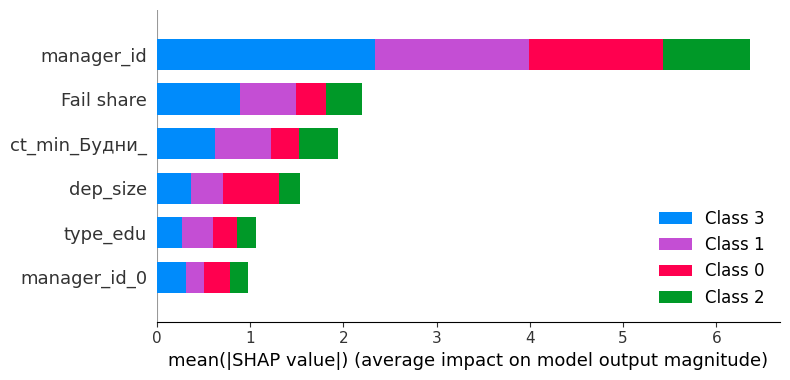

In [469]:
shap_test = shap.TreeExplainer(clf).shap_values(X)
shap.summary_plot(shap_test, X, max_display=25, auto_size_plot=True)

['manager_id', 'Fail_share', 'ct_min_Будни_', 'manager_id_0', 'type_edu', 'dep_size']


<AxesSubplot: >

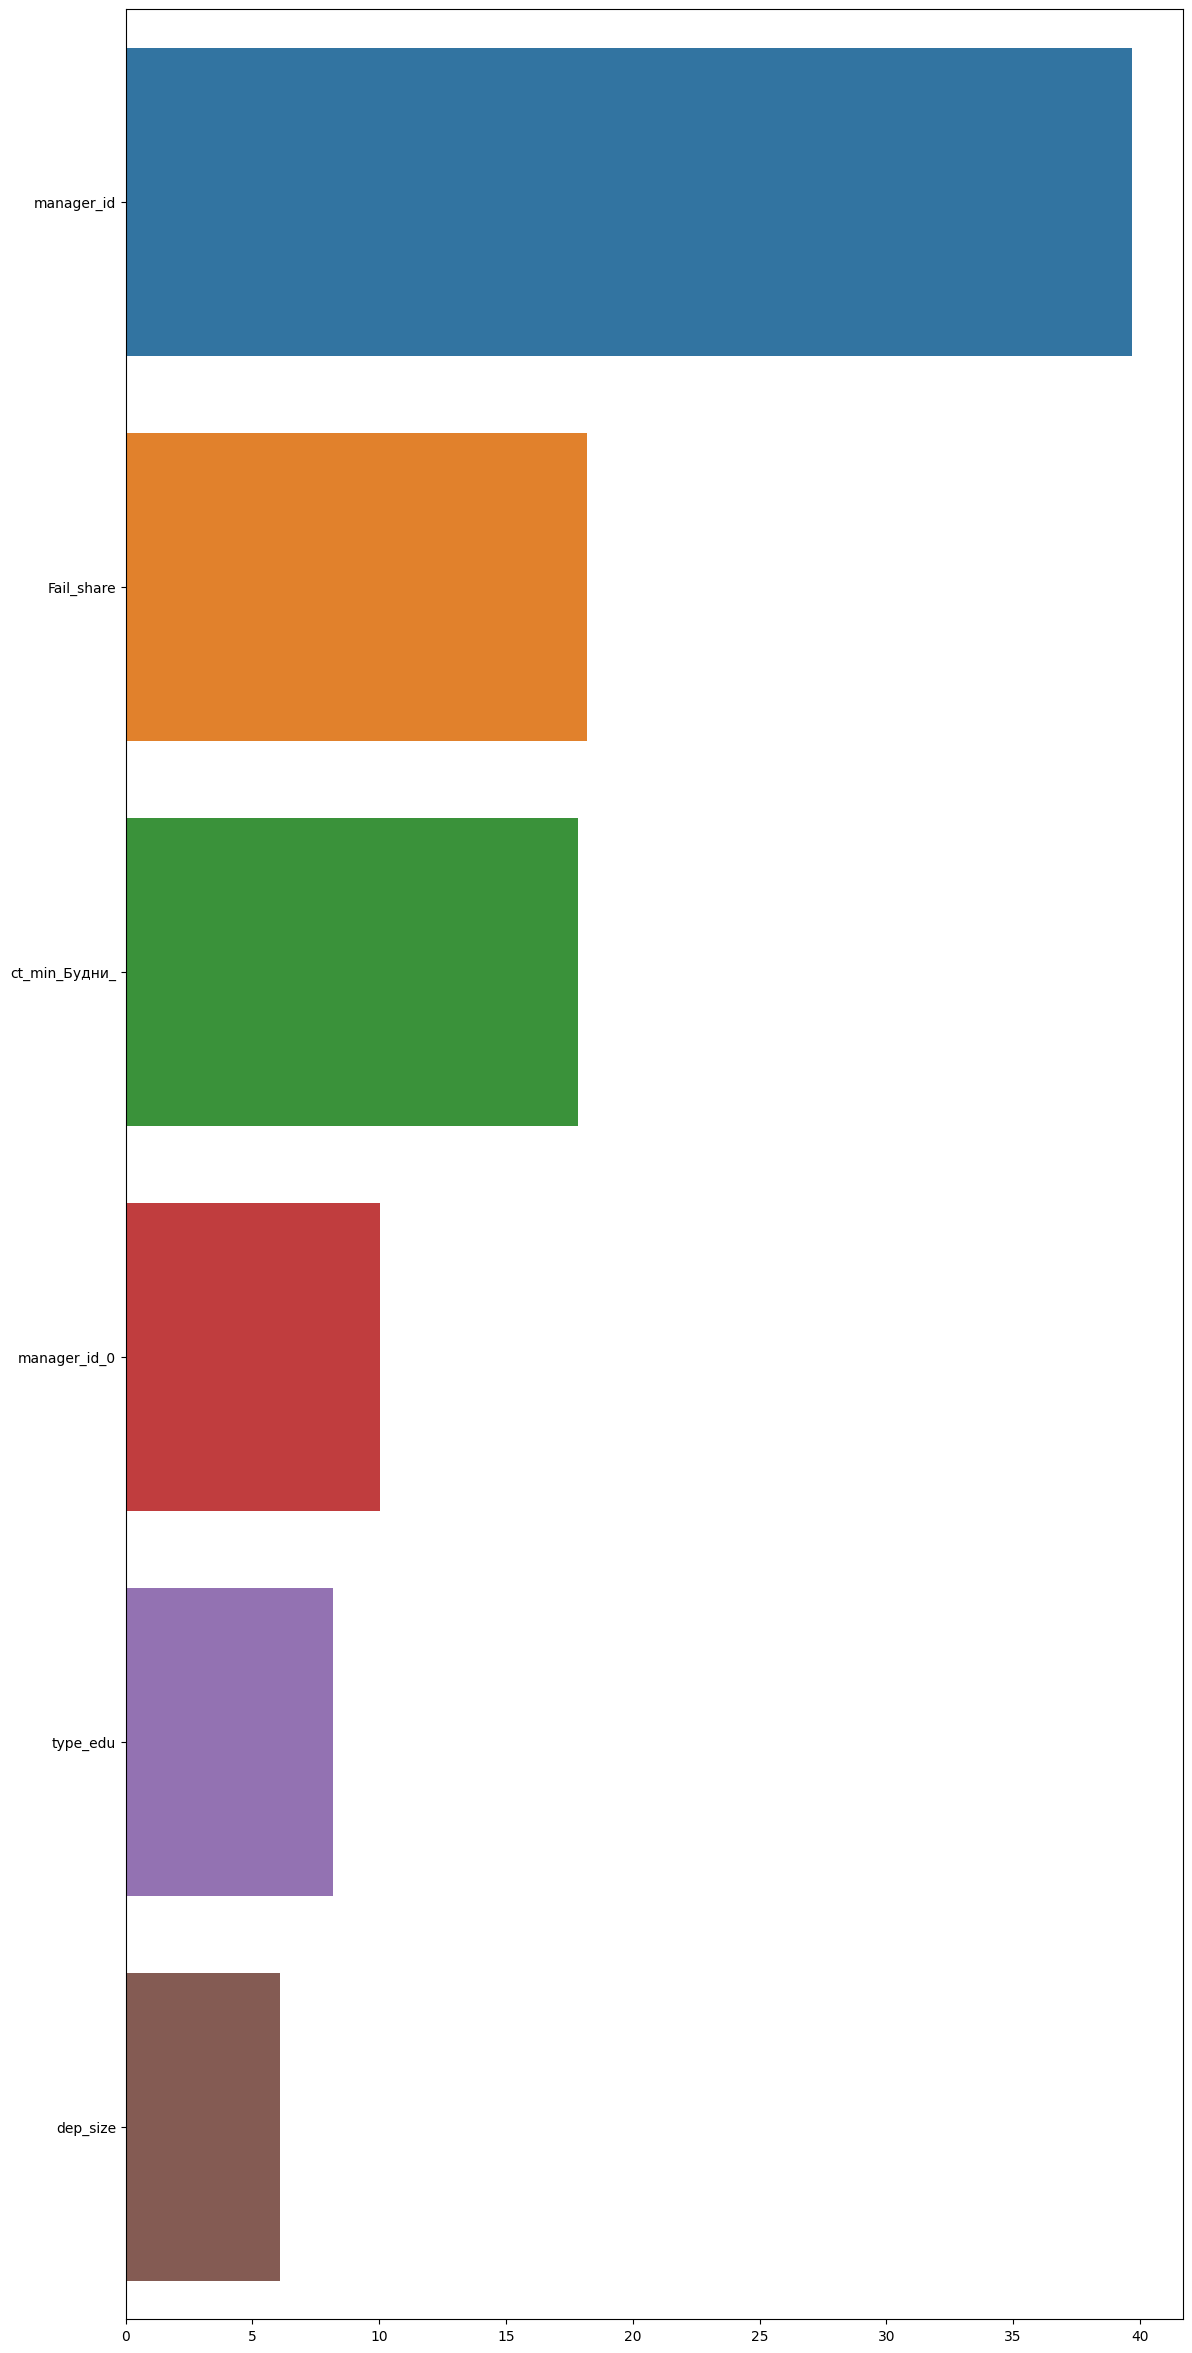

In [470]:
import re
func_ext = clf.feature_importances_
fi = pd.Series(func_ext, index = X.columns).sort_values(ascending = False)
plt.rcParams["figure.figsize"] = (30,30)  
plt.subplot(1,2,1)
temp_index = fi.index.to_list()
temp = []
for _ in temp_index:
    try:
        temp.append(re.sub(r'\W',r'_',str(_)))
    except:
        print(_)
print(temp)
fi.index = temp
sns.barplot(x=fi, y=fi.index)

In [495]:
from sklearn.metrics import recall_score
cv = KFold(n_splits=5, random_state=42, shuffle = True)
#smoter = SMOTE(random_state=42)
ros = SMOTENC(random_state=42,categorical_features = [0,2,4])
scores = []
df_train = df_train.loc[df_train['manager_id_0'] != 0]
X_cv = df_train[columns]#.drop(["id", "type", 'id_0', 'id_1'], axis = 1)[columns]
y_cv = df_train[["type"]]

#cat_features = ['manager_id', 'manager_id_0', 'type_edu'] #, 'type_edu', 
#columns = ["manager_id_0", 'Fail share', 'manager_id', 'dep_size', 'type_edu', 'ct_min_Будни_']#['manager_id', 'manager_id_1', 'dep_size', 'nc_mean_Будни_ToUser_', 'mt_sum_Будни']



clf = CatBoostClassifier(random_state=0, cat_features=cat_features)

for train_fold_index, val_fold_index in cv.split(X_cv, y_cv):
    # Get the training data
    X_train_fold = X_cv.iloc[train_fold_index]
    y_train_fold = y_cv.iloc[train_fold_index]
    # Get the validation data
    X_val_fold = X_cv.iloc[val_fold_index]
    y_val_fold = y_cv.iloc[val_fold_index]
    # Upsample only the data in the training section
    X_train_fold_upsample, y_train_fold_upsample = ros.fit_resample(X_train_fold,
                                                                       y_train_fold)
    # Fit the model on the upsampled training data
    model_obj = clf.fit(X_train_fold_upsample, y_train_fold_upsample)
    # Score the model on the (non-upsampled) validation data
    score = recall_score(y_val_fold, model_obj.predict(X_val_fold),average='macro')
    scores.append(score)

scores


Learning rate set to 0.078631
0:	learn: 1.2769014	total: 70.3ms	remaining: 1m 10s
1:	learn: 1.1875336	total: 172ms	remaining: 1m 25s
2:	learn: 1.1232881	total: 207ms	remaining: 1m 8s
3:	learn: 1.0632319	total: 329ms	remaining: 1m 21s
4:	learn: 1.0099165	total: 411ms	remaining: 1m 21s
5:	learn: 0.9695601	total: 546ms	remaining: 1m 30s
6:	learn: 0.9307504	total: 632ms	remaining: 1m 29s
7:	learn: 0.8952938	total: 782ms	remaining: 1m 36s
8:	learn: 0.8667965	total: 901ms	remaining: 1m 39s
9:	learn: 0.8415799	total: 995ms	remaining: 1m 38s
10:	learn: 0.8209538	total: 1.08s	remaining: 1m 37s
11:	learn: 0.7996868	total: 1.23s	remaining: 1m 41s
12:	learn: 0.7795491	total: 1.32s	remaining: 1m 40s
13:	learn: 0.7631367	total: 1.45s	remaining: 1m 42s
14:	learn: 0.7479350	total: 1.52s	remaining: 1m 40s
15:	learn: 0.7328014	total: 1.59s	remaining: 1m 38s
16:	learn: 0.7202505	total: 1.69s	remaining: 1m 37s
17:	learn: 0.7067648	total: 1.79s	remaining: 1m 37s
18:	learn: 0.6999484	total: 1.86s	remaining:

[0.8496929003600479,
 0.8921130952380952,
 0.8883928571428572,
 0.9314150943396227,
 0.9002265694076039]

In [494]:
X_cv.loc[X_cv['manager_id_0'] != 0]

,manager_id_0,Fail share,manager_id,dep_size,type_edu,ct_min_Будни_
163,ОРГ2,0.000000,ОРГ2-05155,1.0,High education,0.058178
165,ОРГ2,0.076923,ОРГ2-09100,1797.0,High education,0.019027
453,ОРГ1,0.333333,ОРГ1-01773,9.0,High education,0.003871
162,ОРГ1,0.967742,ОРГ1-02181,25.0,High education,0.005635
42,ОРГ1,0.106061,ОРГ1-00920,2.0,High education,0.000000
...,...,...,...,...,...,...
240,ОРГ1,0.580311,ОРГ1-00561,2.0,High education,0.001367
22,ОРГ1,1.000000,ОРГ1-01649,20.0,High education,0.004130
410,ОРГ1,0.000000,ОРГ1-02602,3.0,High education - bachelor,0.000000
149,ОРГ1,0.720721,ОРГ1-01955,1.0,High education,0.005092
